<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

ResNet50 = ResNet50(weights='imagenet')
features = model.predict(x)

```

Next you will need to remove the last layer from the ResNet model. Here, we loop over the layers to use the sequential API. There are easier ways to add and remove layers using the Keras functional API, but doing so introduces other complexities. 

```python
# Remote the Last Layer of ResNEt
ResNet50._layers.pop(0)

# Out New Model
model = Sequential()

# Add Pre-trained layers of Old Model to New Model
for layer in ResNet50.layers:
    model.add(layer)

# Turn off additional training of ResNet Layers for speed of assignment
for layer in model.layers:
    layer.trainable = False

# Add New Output Layer to Model
model.add(Dense(1, activation='sigmoid'))
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

### Fetch Pre-Trained Network

In [1]:
def build_resnet_50(num_classes, optim_name='adam'):
    from tensorflow.keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.applications.resnet50 import ResNet50
    from tensorflow.keras.models import Model

    base_model = ResNet50(include_top=True, weights='imagenet')
    x = base_model.layers[-2].output
    del base_model.layers[-1:]
    
    # Freeze layers in base_model
    for layer in base_model._layers:
        layer.trainable = False
    
    # Define new output layer
    x = Dense(num_classes, activation='softmax', name='Predictions_a')(x)
#     x = Dense(num_classes, activation='sigmoid', name='Predictions_b')(x)
    
    
    # Build and compile new model with base_model as input (base_model.input) and output layer(s)
    model = Model(base_model.input, x)
    model.compile(optimizer=optim_name, loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

### Convert Images


In [31]:
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import pandas as pd

# Get list of files
path_forest = os.path.join(os.getcwd(), 'data/forest')
path_mountain = os.path.join(os.getcwd(), 'data/mountain')


def concat_path(base, name):
    return base + '/' + name

# Create full paths to all items in directories and filter for files only
forest_images = [concat_path(path_forest, path) for path in os.listdir(path_forest) if os.path.isfile(concat_path(path_forest, path))]
mountain_images = [concat_path(path_mountain, path) for path in os.listdir(path_mountain) if os.path.isfile(concat_path(path_mountain, path))]


# Generate datasets for paths and category.  (0) Forest, (1) Moutnain
forest_data = list(zip(forest_images, np.zeros(len(forest_images))))
mountain_data = list(zip(mountain_images, np.ones(len(mountain_images))))


data = pd.DataFrame(forest_data + mountain_data)
data.columns = ['path', 'category']
# data.forest_paths = path_forest + '/' + data.forest_paths
# data.mountain_paths = path_mountain + '/' + data.mountain_paths



In [32]:
data.head()

,path,category
0,/mnt/cluster_share/lambda_school/week_14/DS-Un...,0.0
1,/mnt/cluster_share/lambda_school/week_14/DS-Un...,0.0
2,/mnt/cluster_share/lambda_school/week_14/DS-Un...,0.0
3,/mnt/cluster_share/lambda_school/week_14/DS-Un...,0.0
4,/mnt/cluster_share/lambda_school/week_14/DS-Un...,0.0


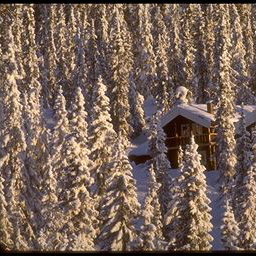

0.0

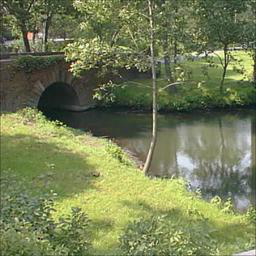

0.0

In [33]:
for i in range(2):
    display(image.load_img(data.path[i]), data.category[i])

In [36]:
from tensorflow.keras.preprocessing.image import img_to_array

path = data.path[2]
im = image.load_img(path, target_size=(224,224))
im = img_to_array(im)/255
im.shape

(224, 224, 3)

In [35]:
# Get image arrays
from tensorflow.keras.preprocessing.image import img_to_array

def get_transform_img(img_path):
    im = image.load_img(img_path, target_size=(224,224))
    im = preprocess_input(img_to_array(im))
    return im

data['images'] = data.path.apply(get_transform_img)

In [37]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

X = []
for info in data.images:
    X.append(info)
    
X = np.array(X)
display(X.shape)

y = data.category.to_numpy().reshape(-1,1)
y = encoder.fit_transform(y).todense()
display(y.shape)

(702, 224, 224, 3)

/home/vbrandon/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(702, 2)

In [39]:
y[0], encoder.categories_

(matrix([[1., 0.]]), [array([0., 1.])])

In [40]:
# Create train, test, split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=426)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(631, 224, 224, 3)

(71, 224, 224, 3)

(631, 2)

(71, 2)

In [41]:
X_train[0].shape

(224, 224, 3)

### Fit Model

In [42]:
# Get model with correct number of classes specified
model = build_resnet_50(num_classes=2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [43]:
# Fit model
model.fit(
    x=X_train, y=y_train,
    batch_size=32,
    epochs=5,
)

Train on 631 samples
Epoch 1/5
631/631 [==============================] - 39s 62ms/sample - loss: 0.3681 - accuracy: 0.8415
Epoch 2/5
631/631 [==============================] - 37s 59ms/sample - loss: 0.1030 - accuracy: 0.9635
Epoch 3/5
631/631 [==============================] - 37s 59ms/sample - loss: 0.0734 - accuracy: 0.9810
Epoch 4/5
631/631 [==============================] - 37s 59ms/sample - loss: 0.0561 - accuracy: 0.9826
Epoch 5/5
631/631 [==============================] - 37s 59ms/sample - loss: 0.0481 - accuracy: 0.9921


In [44]:
model.evaluate(X_test, y_test)

71/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.08741045858658536, 0.97183096]

In [45]:
display(model.predict(X_test)[0:10], y_test[0:10])

array([[4.1301030e-01, 5.8698970e-01],
       [5.7064318e-03, 9.9429351e-01],
       [9.5269454e-01, 4.7305491e-02],
       [9.9672771e-01, 3.2722873e-03],
       [9.9999642e-01, 3.5212427e-06],
       [9.9997616e-01, 2.3809775e-05],
       [2.0994529e-01, 7.9005468e-01],
       [4.0412586e-02, 9.5958745e-01],
       [3.9218497e-04, 9.9960786e-01],
       [9.9995148e-01, 4.8508107e-05]], dtype=float32)

matrix([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])

In [89]:
pred = model.predict(X_test)[0:10]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


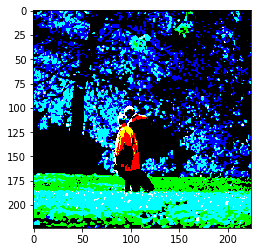

In [94]:
import matplotlib.pyplot as plt

plt.imshow(X_test[4])

In [100]:
def decode_output(array):
    test = np.argmax(array)
    if test == 0:
        return 'Forest'
    return 'Mountain'

display(
    list(map(decode_output, pred)),
    list(map(decode_output, y_test[0:10]))
)

['Mountain',
 'Mountain',
 'Forest',
 'Forest',
 'Forest',
 'Forest',
 'Mountain',
 'Mountain',
 'Mountain',
 'Forest']

['Mountain',
 'Mountain',
 'Forest',
 'Forest',
 'Forest',
 'Forest',
 'Mountain',
 'Mountain',
 'Mountain',
 'Forest']

)# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language